In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc3 as pm
import pandas as pd
import theano

import itertools

plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (8,5)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
SEED = 42
np.random.seed(SEED)

The dataset used for the analysis comes from this [source](https://stats.idre.ucla.edu/stat/examples/imm/imm10.dta). The dataset is in stata file (v110, not supported by `pd.read_stata`) format you might want to convert it to a csv file before using with pandas. The data contains the math scores of students from different schools and backgrounds. For our purposes, we are interested in identifying the relationship between math scores and homework for students from 10 schools.

In [3]:
data = pd.read_csv('mlmldata.csv')
data.head()

,schid,stuid,ses,meanses,homework,white,parented,public,ratio,percmin,math,sex,race,sctype,cstr,scsize,urban,region,schnum
0,7472,3,-0.13,-0.482609,1,1,2,1,19,0,48,2,4,1,2,3,2,2,1
1,7472,8,-0.39,-0.482609,0,1,2,1,19,0,48,1,4,1,2,3,2,2,1
2,7472,13,-0.80,-0.482609,0,1,2,1,19,0,53,1,4,1,2,3,2,2,1
3,7472,17,-0.72,-0.482609,1,1,2,1,19,0,42,1,4,1,2,3,2,2,1
4,7472,27,-0.74,-0.482609,2,1,2,1,19,0,43,2,4,1,2,3,2,2,1


In [4]:
# Helpers

# plot line with slope and intercept
def abline(slope, intercept, ax=None, **kwargs):
    """Plot a line from slope and intercept"""
    axes = ax if ax else plt.gca()
    x_vals = np.array([0,7])
    y_vals = intercept + slope * x_vals
    axes.plot(x_vals, y_vals,  **kwargs)
    
# facet with defaults specific to this data
def facetgrid(func):
    """ func is a function that takes the group df, matplotlib axes, group ID
        func must plot using the axes
    """
    fig, ax = plt.subplots(2, 5, figsize=(16,7), 
                           sharex=True, sharey=True,
                            constrained_layout=True)
    
    groups = data.groupby('schid')  # 10 schools
    grp_ids = list(groups.groups)
    
    for i, j in itertools.product(range(2), range(5)):
        grp_id = grp_ids[i * 5 + j]
        func(groups.get_group(grp_id), ax[i,j], grp_id)
        ax[i,j].set_title('schid : ' + str(grp_id), fontweight='bold')
        
    fig.text(0.5, -0.03, 'homework', ha='center', fontsize=16)
    fig.text(-0.02, 0.5, 'math', va='center', rotation='vertical', fontsize=16)
    handles, labels = ax[-1,-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.98, 0.98))
    
# colors from BMH style
red = '#A60628'
blue = '#0072B2'
green = '#467821'
violet = '#7A68A6'
orange = '#D55E00'
pink = '#CC79A7'

Text(0, 0.5, 'math')

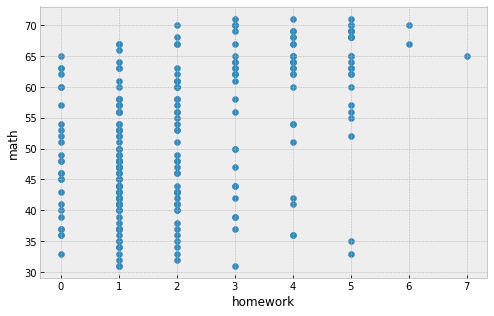

In [5]:
def plot_data(df, ax=None, grp_id=None, **kwargs):
    if not ax:
        fig, ax = plt.subplots()
    ax.scatter(df['homework'], df['math'], **kwargs)
    return ax
    
ax = plot_data(data)
ax.set_xlabel('homework')
ax.set_ylabel('math')

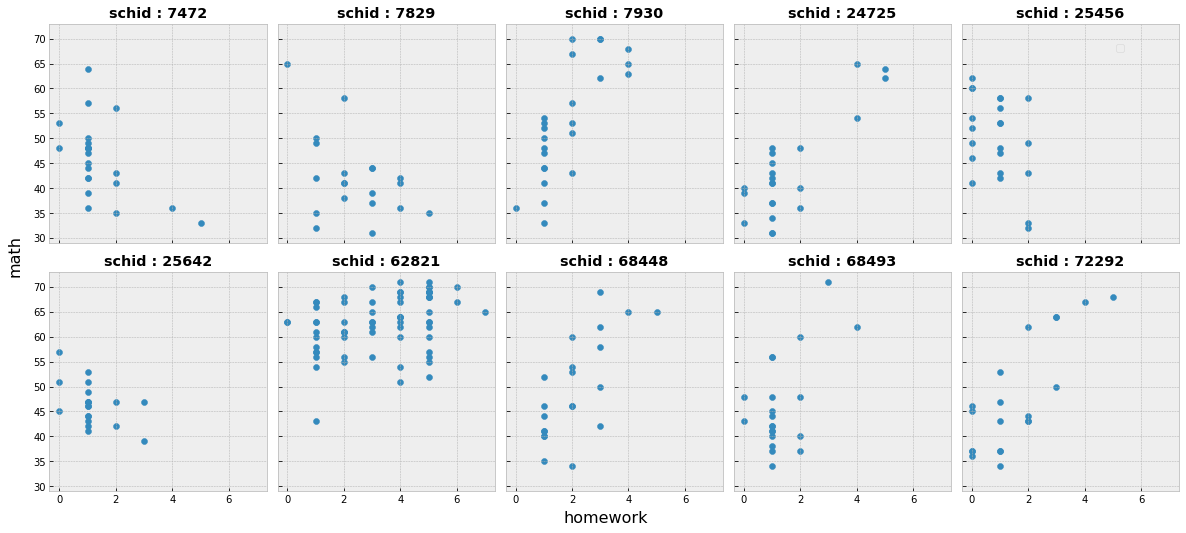

In [6]:
facetgrid(plot_data)

There is a significant variation in the relationship across different groups. Clearly, a single model will not be able to capture it.

# Unpooled linear regression

Let us fit a model on the entire dataset. For simplicity, I will use an ols regression model

In [7]:
from statsmodels.formula.api import ols

unpooled_model = ols('math ~ homework', data).fit()
unpooled_est = unpooled_model.params

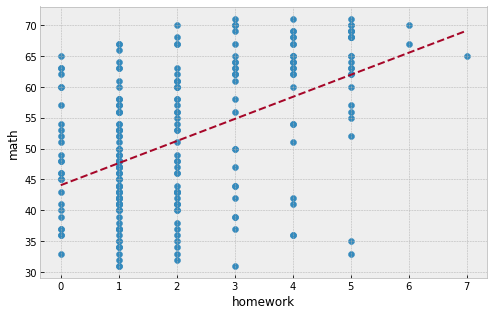

In [8]:
m = unpooled_est['homework']
c = unpooled_est['Intercept']

plt.scatter(data['homework'], data['math'])
plt.xlabel('homework')
plt.ylabel('math')

abline(m, c, linestyle='--', color=red)

# Pooled linear regression

We will estimate different parameters for different groups in the data. Again for simplicity, I'm using OLS regression

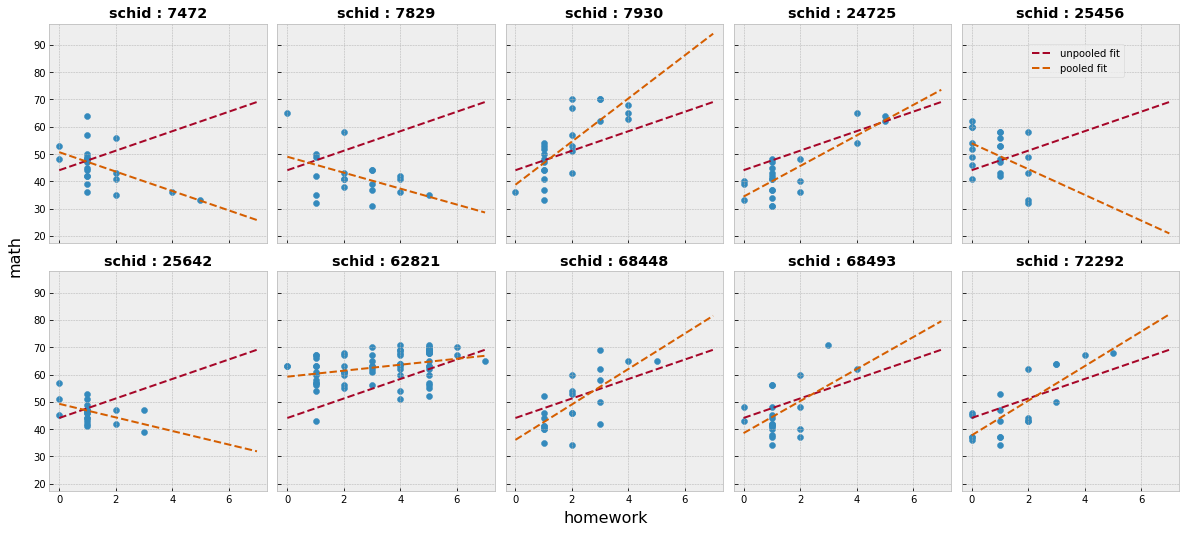

In [9]:
pooled_est = {}  # scid : (m, c)

def pooled_model(df, ax, grp_id):
    pooled_model = ols('math ~ homework', df).fit()
    pooled_params = pooled_model.params
    
    mp = pooled_params['homework']
    cp = pooled_params['Intercept']
    
    # save estimates of the group
    pooled_est[grp_id] = (mp, cp)
    
    # plot along with unpooled regression line
    plot_data(df, ax, grp_id)
    abline(m, c, ax, linestyle='--', color=red, label='unpooled fit')
    abline(mp, cp, ax, linestyle='--', color=orange, label='pooled fit')
    
facetgrid(pooled_model)

# Partial pooling

We will perform bayesian hierarchical modeling using PyMC3. We will construct hyper priors on our group level parameters to allow the model to share student level coefficients among the groups withing the data. The model can be represented as:

$$ y_i = \alpha_{ji} + \beta_{ji}x_i + \epsilon_i $$

or in probabilistic notation:

$$ y \sim N(\alpha_{j} + \beta_{j}x, \epsilon) $$

where j is the school index.

For this model I will use a random slope and intercept, meaning both of them will have an hyper prior on them. 

In [10]:
from sklearn.preprocessing import LabelEncoder

sch_le = LabelEncoder()

school = sch_le.fit_transform(data['schid'])
n_schools = len(sch_le.classes_)
homework = data.homework
math = data.math

In [11]:
with pm.Model() as model:
    # Hyperpriors
    mu_a = pm.Normal('mu_a', mu=40, sigma=50)
    sigma_a = pm.HalfNormal('sigma_a', 50)
    
    mu_b = pm.Normal('mu_b', mu=0, sigma=10)
    sigma_b = pm.HalfNormal('sigma_b', 5)
    
    # Intercept
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_schools)
    # Slope
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_schools)
    
    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    y_hat = a[school] + b[school] * homework
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=eps, observed=math)

Let's run inference with NUTS sampler for the model above

In [12]:
with model:
    step = pm.NUTS()
    trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 13 seconds.


## Posterior distributions

/run/media/surya/F/codes/python/data sci/bayesian/bayesenv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e37549668>,
      dtype=object)

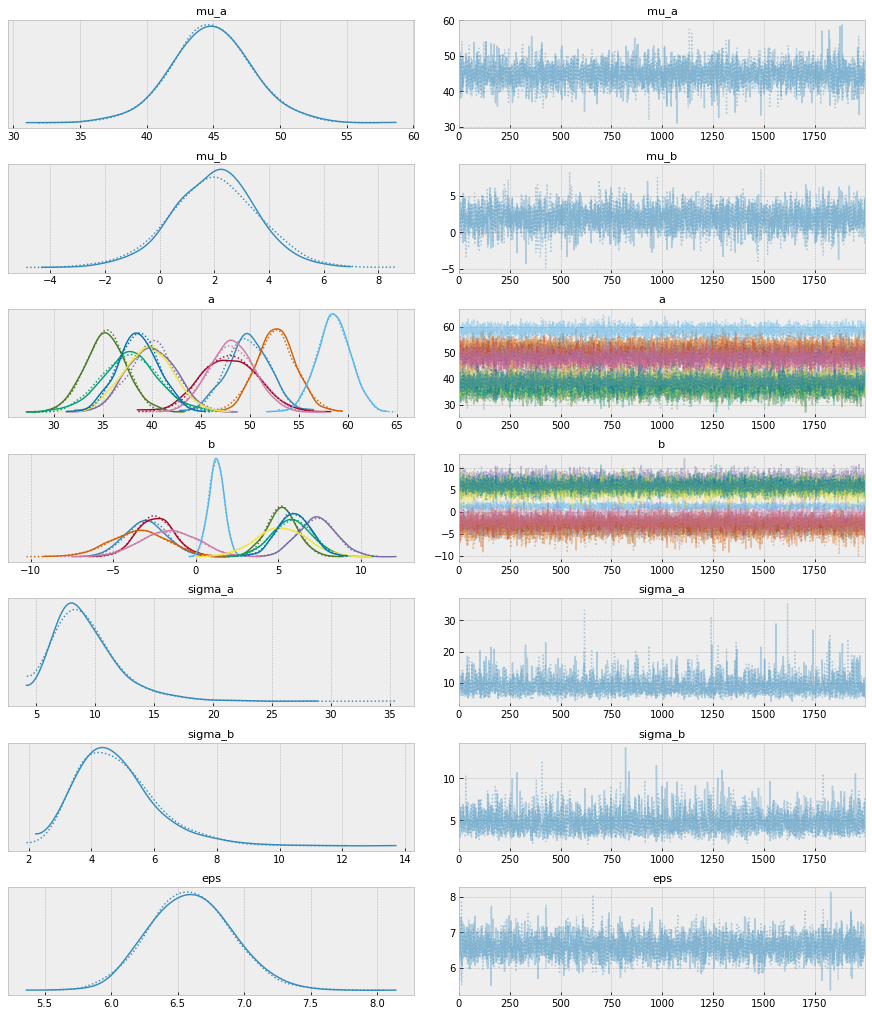

In [13]:
pm.traceplot(trace)

/run/media/surya/F/codes/python/data sci/bayesian/bayesenv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/run/media/surya/F/codes/python/data sci/bayesian/bayesenv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Text(-0.02, 0.5, 'school')

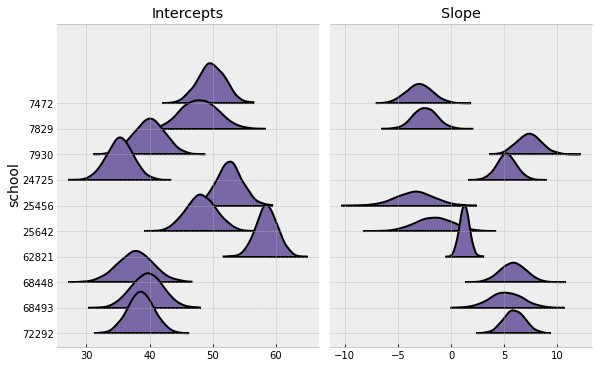

In [14]:
fig, ax = plt.subplots(1,2, sharey=True, constrained_layout=True)

sch_ids  = sch_le.classes_[::-1]

pm.forestplot(trace, 'ridgeplot', var_names=['a'], 
              combined=True,
              ridgeplot_overlap=5,
              colors=violet,
              figsize=(5, 10), ax=ax[0])
ax[0].set_title('Intercepts')
ax[0].set_yticklabels(sch_ids)
ax[0].grid()
pm.forestplot(trace, 'ridgeplot', var_names=['b'], 
              combined=True,
              ridgeplot_overlap=5,
              colors=violet,
              figsize=(5, 10), ax=ax[1])
ax[1].set_title('Slope')
ax[1].set_yticklabels(sch_ids)
ax[1].grid()
fig.text(-0.02, 0.5, 'school', va='center', rotation='vertical', fontsize=14)

In [15]:
def plot_posterior_regression_lines(m_p, c_p, ax=None, **kwargs):
    """
    m_p, c_p : posterior samples of slope and intercept respectively
    """
    if not ax:
        fig, ax = plt.subplots()
    
    for (m, c) in zip(m_p, c_p):
        abline(m, c, ax, **kwargs)

## Plot regression lines

We will plot all the regression lines from our posterior sample

Text(0, 0.5, 'math')

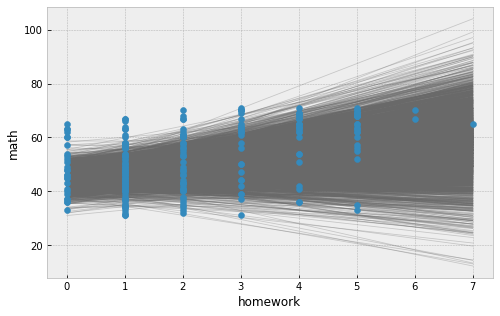

In [16]:
fig, ax = plt.subplots()
plot_posterior_regression_lines(trace['mu_b'], trace['mu_a'], ax, color='dimgray', alpha=0.3, lw=0.8)
# abline(trace['mu_b'].mean(), trace['mu_a'].mean(), ax, color=red, linestyle='-.')
plot_data(data, ax, zorder=3)
ax.set_xlabel('homework')
ax.set_ylabel('math')

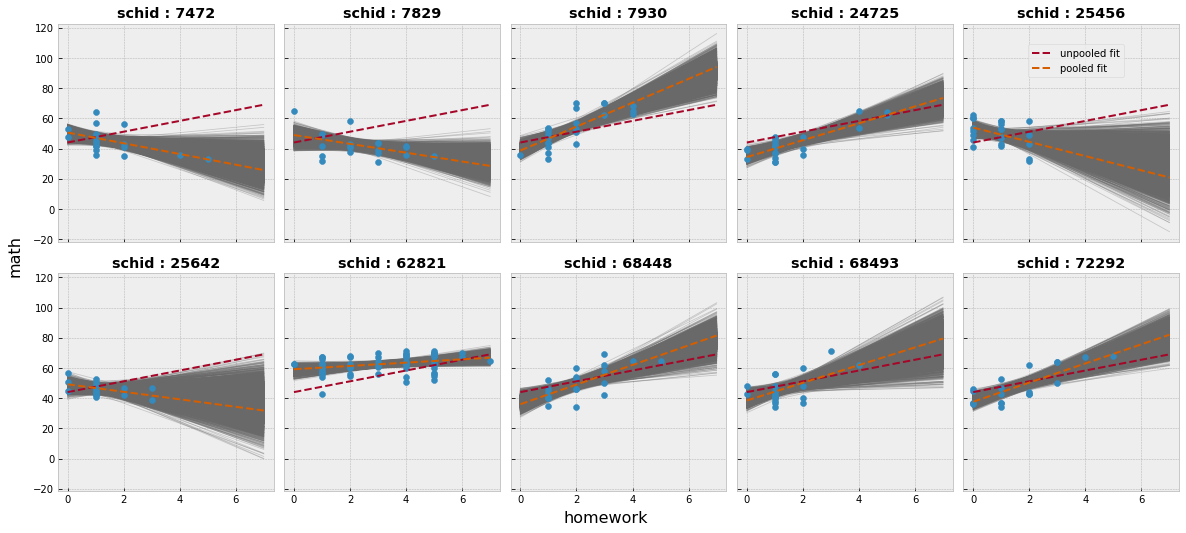

In [17]:
def posterior_plot(df, ax, grp_id):
    grp_label = sch_le.transform([grp_id])[0]
    m_p = trace['b'][:,grp_label]
    c_p = trace['a'][:,grp_label]
    
    plot_posterior_regression_lines(m_p, c_p, ax, color='dimgray', alpha=0.3, lw=0.8)
    
    (mp, cp) = pooled_est[grp_id]
    
    plot_data(df, ax, grp_id, zorder=3)
    abline(m, c, ax, linestyle='--', color=red, label='unpooled fit', zorder=4)
    abline(mp, cp, ax, linestyle='--', color=orange, label='pooled fit', zorder=4)
    
facetgrid(posterior_plot)

Note the general higher uncertainity around groups that show a negative slope. The model implies that we must be a little more careful with decisions derived from the model on certain groups. Note with more data and lesser deviation, the bayesian model converges to the OLS model.

In [20]:
# # Get colors
# cols =  plt.style.library['bmh']['axes.prop_cycle']
# for i, col in enumerate(cols):
#     print(col)
#     plt.plot([0, 5], [1+i,1+i], color=col['color'], label=col['color'])
# plt.legend()